# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import lateness_scheduling as lp_lateness
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60 * 6 # 6 min

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J0,9,49,1440,1109.0
1,J1,5,130,1440,1104.0
2,J2,3,151,1440,1437.0
3,J3,4,226,1440,998.0
4,J4,6,386,1440,1203.0
...,...,...,...,...,...
15,J15,5,1142,1440,2116.0
16,J16,6,1254,1440,2071.0
17,J17,7,1285,1440,2343.0
18,J18,8,1397,1440,2569.0


## a) Absolute Lateness Summe

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [4]:
# Scheduling
df_schedule = lp_lateness.solve_jssp_sum(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe absolute Lateness  : 69.0
  Solver-Status            : Optimal
  Anzahl Variablen         : 2140
  Anzahl Constraints       : 4040
  Laufzeit                 : ~245 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J0,0,M01,85,9,49,1440,1109.0,216.0,301.0,-808.0,808.0
1,J0,1,M00,13,9,49,1440,1109.0,301.0,314.0,-795.0,795.0
2,J0,2,M02,61,9,49,1440,1109.0,314.0,375.0,-734.0,734.0
3,J0,3,M06,7,9,49,1440,1109.0,375.0,382.0,-727.0,727.0
4,J0,4,M08,64,9,49,1440,1109.0,411.0,475.0,-634.0,634.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,J19,5,M09,76,9,1398,1440,2458.0,2059.0,2135.0,-323.0,323.0
196,J19,6,M05,47,9,1398,1440,2458.0,2135.0,2182.0,-276.0,276.0
197,J19,7,M03,52,9,1398,1440,2458.0,2182.0,2234.0,-224.0,224.0
198,J19,8,M04,90,9,1398,1440,2458.0,2234.0,2324.0,-134.0,134.0


In [5]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              17
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


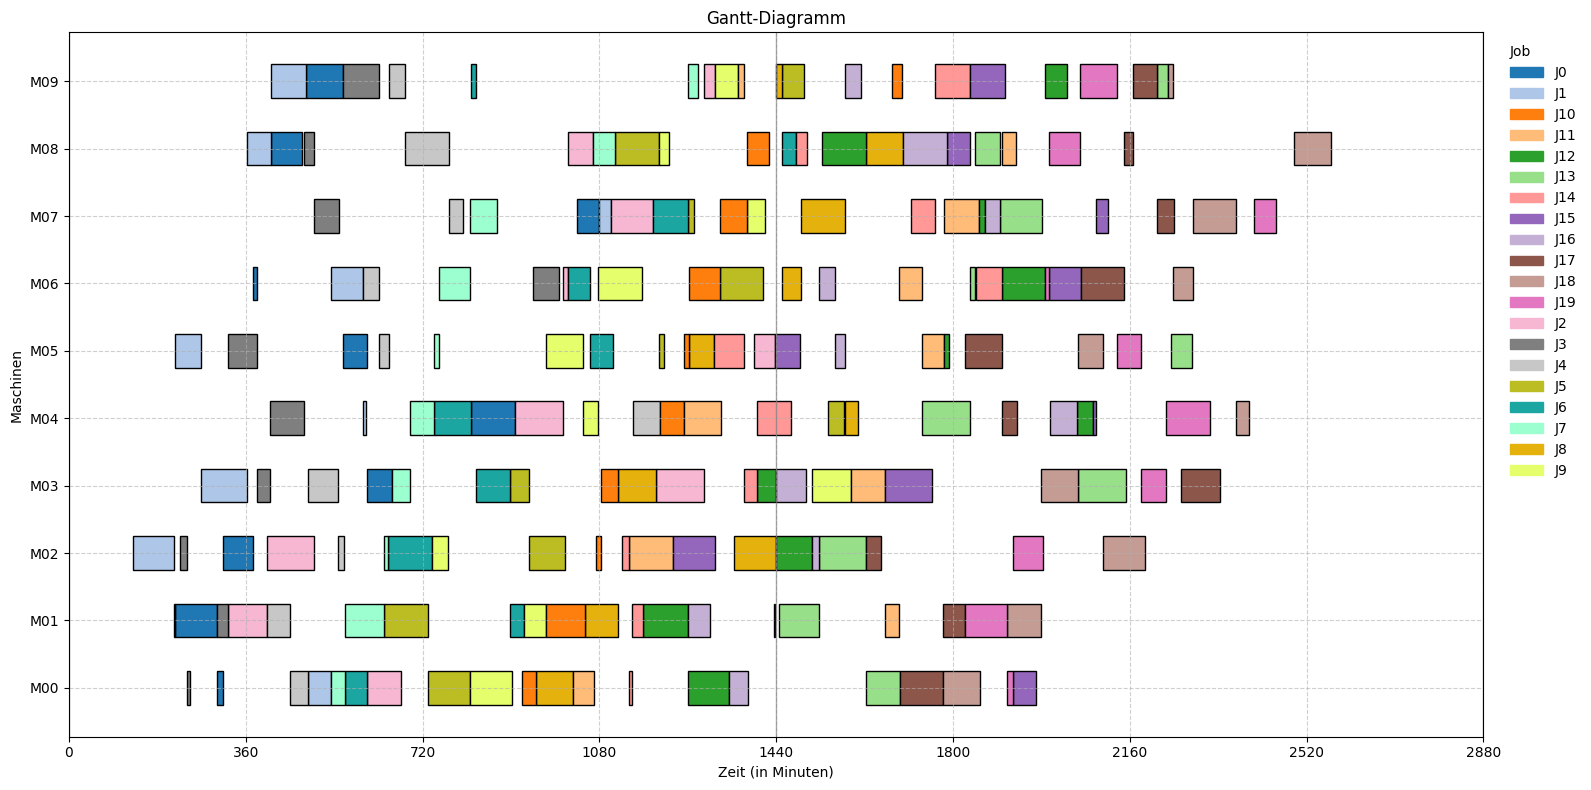

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## b) größte absolute Lateness minimieren

$$
\min \; \max_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **größte Abweichung** eines Jobs zur Deadline – unabhängig davon, ob der Job **zu früh oder zu spät** fertiggestellt wurde.  
Sie sorgt dafür, dass **kein Job extrem abweicht**, und behandelt **Früh- und Spätfertigstellungen gleichwertig**.


In [7]:
# Scheduling
df_schedule = lp_lateness.solve_jssp_max(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_schedule

BigM: 6000

Solver-Informationen:
  Maximale absolute Lateness : 19.5
  Solver-Status              : Optimal
  Anzahl Variablen           : 2141
  Anzahl Constraints         : 4060
  Laufzeit                   : ~14 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Lateness,Absolute Lateness
0,J0,0,M01,85,9,49,1440,1109.0,326.0,411.0,0.0,0.0
1,J0,1,M00,13,9,49,1440,1109.0,411.0,424.0,0.0,0.0
2,J0,2,M02,61,9,49,1440,1109.0,424.0,485.0,0.0,0.0
3,J0,3,M06,7,9,49,1440,1109.0,485.0,492.0,0.0,0.0
4,J0,4,M08,64,9,49,1440,1109.0,524.0,588.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,J19,5,M09,76,9,1398,1440,2458.0,2060.0,2136.0,0.0,0.0
196,J19,6,M05,47,9,1398,1440,2458.0,2177.0,2224.0,0.0,0.0
197,J19,7,M03,52,9,1398,1440,2458.0,2224.0,2276.0,0.0,0.0
198,J19,8,M04,90,9,1398,1440,2458.0,2276.0,2366.0,0.0,0.0


In [8]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              14
0 - 60          6
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


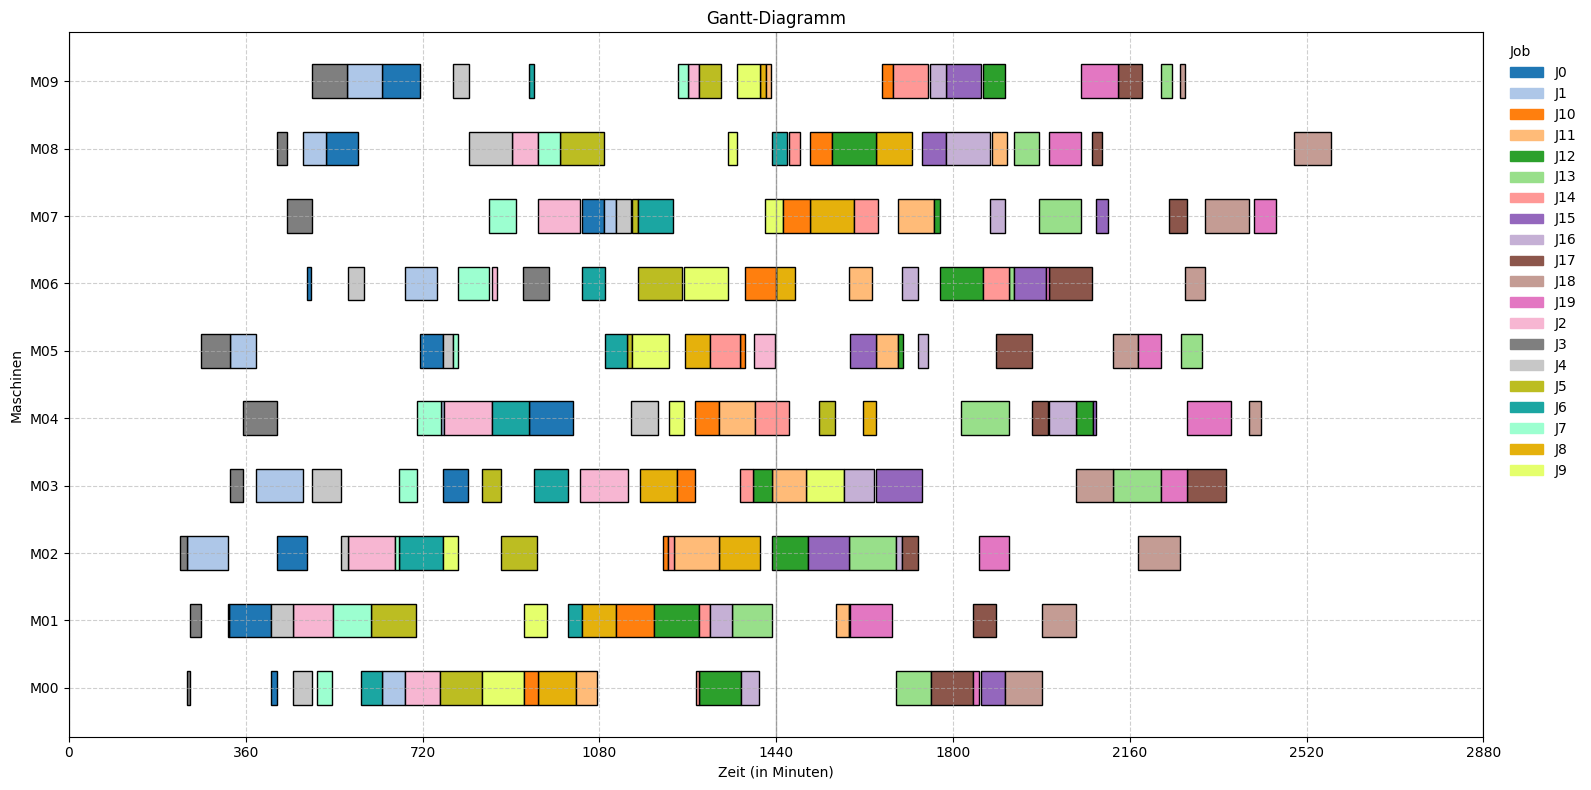

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [9]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)